The first possible strategy for building a computer opponent is to make shots totally at random.

In [1]:
import random as pyrandom
from Gameboard import *

First we write function to generate random board location.

In [2]:
def get_random_location():
    row_str = pyrandom.choice(Gameboard.row_labels)
    col_str = pyrandom.choice(Gameboard.col_labels)
    return row_str + str(col_str)

In [3]:
get_random_location()

'B8'

That's fine but we want to choose a random location from locations which are not aleady selected. For that, we create Random class. When it's instantiated, list of available locations is initialized. When a random location is chosen, it's taken out from available locations list.

In [4]:
class Random:
    def __init__(self):
        # possible locations list isn't affected by the methods
        self.possible_locations = []
        self.available_locations = []
        for i in Gameboard.row_labels:
            for j in Gameboard.col_labels:
                self.possible_locations.append(i + str(j))
                self.available_locations.append(i + str(j))
        
    def reset_available_locations(self):
        self.available_locations = self.possible_locations.copy()
        
    # chooses random location from available locations list and removes it if keep is False
    def choose(self, keep=False):
        choice = pyrandom.choice(self.available_locations)
        if not keep:
            self.available_locations.remove(choice)
        return choice
    
    # returns random location from possible locations list
    def choose_from_all(self):
        return pyrandom.choice(self.possible_locations)

In [5]:
%%capture
random = Random()

# create Gameboard object
board = Gameboard()

# manually add ships
board.hide_ship('A2', 'A3', 'A4')
board.hide_ship('C2', 'C3', 'C4', 'C5', 'C6')
board.hide_ship('E3', 'F3')
board.hide_ship('F5', 'G5', 'H5', 'I5')
board.hide_ship('D9', 'E9', 'F9')

# run one game
while True:
    board.shoot(random.choose())
    if board.is_game_over():
        break

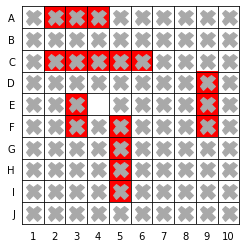

In [6]:
board.get_figure()

Before we run multiple simulations with random strategy, it's natural to extend Random class so that random boat combinations can be generated.

In [7]:
class Random:
    def __init__(self):
        # possible locations list isn't affected by the methods
        self.possible_locations = []
        self.available_locations = []
        for i in Gameboard.row_labels:
            for j in Gameboard.col_labels:
                self.possible_locations.append(i + str(j))
                self.available_locations.append(i + str(j))
        
    def reset_available_locations(self):
        self.available_locations = self.possible_locations.copy()
        
    # chooses random location from available locations list and removes it if keep is False
    def choose(self, keep=False):
        choice = pyrandom.choice(self.available_locations)
        if not keep:
            self.available_locations.remove(choice)
        return choice
    
    # returns random location from possible locations list
    def choose_from_all(self):
        return pyrandom.choice(self.possible_locations)
    
    # generates random locations for ships of various length and returns them
    # WARGING: current implementation is not optimal and should be changed sometime in the future
    # NOTE: this method currently uses choose method but it resets available locations at the end
    def generate_ship_locations(self, lengths=[5, 4, 3, 3, 2]):
        locations = []
        
        for length in lengths:
            orientation = pyrandom.choice(['horizontal', 'vertical'])
            
            # randomize a ship location until it fits
            while True:
                choice_pivot = self.choose(keep=True)
                choices = [choice_pivot]
                if orientation == 'horizontal':   
                    # generate all other choices (for horizontal orientation)
                    for i in range(length - 1):
                        # when orientation is horizontal, column is changed
                        choice_next = choice_pivot[0] + str(int(choice_pivot[1:]) + i + 1)
                        choices.append(choice_next)
                else:
                    # generate all other choices (for vertical orientation)
                    for i in range(length - 1):
                        # when orientation is vertical, row is changed
                        choice_next = chr(ord(choice_pivot[0]) + i + 1) + choice_pivot[1:]
                        choices.append(choice_next)
                # after generation, we must check if locations are legal
                is_legal = True
                for choice in choices:
                    if choice not in self.available_locations:
                        is_legal = False
                # if they're legal, we update available locations and break the loop
                if is_legal:
                    self.available_locations = [x for x in self.available_locations if x not in choices]
                    locations += choices
                    break
        
        # reset available locations and return result
        self.reset_available_locations()
        return locations

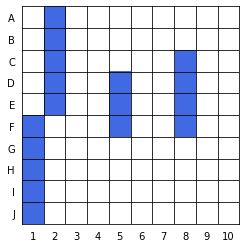

In [8]:
# test generate_ship_locations method
random = Random()
board.clear()
board.hide_ship(*random.generate_ship_locations())
board.get_figure()

In [9]:
%%capture
board = Gameboard()
random = Random()

Let's run a single simulation again (now with random ship locations) and time it.

In [10]:
%%timeit
# add ships on random location
board.hide_ship(*random.generate_ship_locations())

# run one game
while True:
    board.shoot(random.choose())
    if board.is_game_over():
        break

# clear gameboard
board.clear()
# reset available locations
random.reset_available_locations()

2.02 ms ± 208 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


We see that a single loop currently takes 2ms, So 1 million simulations will take 35 minutes. We're going to do that in separate .py file. In this notebook, we'll run 1000 simulations and plot the results.

In [11]:
# array containing shot count of each game
shots = []
# array containing accuracy of each game
accuracies = []

for i in range(1000):
    # add ships on random location
    board.hide_ship(*random.generate_ship_locations())

    # run one game
    while True:
        board.shoot(random.choose())
        if board.is_game_over():
            break
            
    # capture statistics
    shots.append(board.get_shot_count())
    accuracies.append(board.get_accuracy())

    # clear gameboard
    board.clear()
    # reset available locations
    random.reset_available_locations()

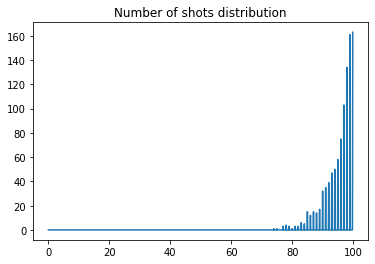

In [12]:
hist = np.histogram(shots, bins=len(shots), range=(0, 100))
plt.plot(hist[1][:-1], hist[0])
plt.title('Number of shots distribution')
plt.show()

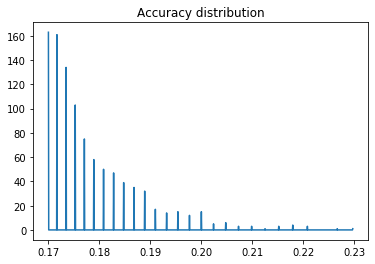

In [13]:
hist = np.histogram(accuracies, bins=len(accuracies))
plt.plot(hist[1][:-1], hist[0])
plt.title('Accuracy distribution')
plt.show()

**Note:** accuracy cannot be less than $\cfrac{\text{# of ships}}{100}$, which is $\cfrac{5 + 4 + 3 + 3 + 2}{100} = 0.17$ in this case.